# Springboard Ultimate Challenge

## This 3-part challenge required by Springboard Data Science Track includes exploratory data analysis (EDA), metrics design, and predictive modeling.

## Part 1 - EDA of user logins and patterns of demand

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
logins_df = pd.read_json (r'logins.json')

In [3]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins_df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648247
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


#### There are about 93,000 timestamps from early 1970, no blanks, ranging from Jan 1st 20:12 to April 13th 18:57.  The order is not an exact sort.

In [7]:
logins_df.nunique()

login_time    92265
dtype: int64

In [8]:
logins_df.value_counts().head()

login_time         
1970-04-12 04:03:15    3
1970-02-12 11:16:53    3
1970-03-14 17:45:52    3
1970-01-06 21:45:52    3
1970-04-04 01:17:40    3
dtype: int64

In [9]:
logins_dupes = logins_df.login_time.value_counts().to_frame()

In [10]:
logins_dupes.login_time.value_counts()

1    91397
2      859
3        9
Name: login_time, dtype: int64

#### Of 93,142 records, 98% appear once.  859 timestamps are doubled and 9 are listed at most three times, and could possibly be simultaneous logins by multiple users.

In [3]:
logins_df.sort_values(by='login_time', inplace = True)

### Explore dates and counts:

In [4]:
# add months and days, make timestamp index
logins_df['month']= logins_df.login_time.dt.month_name()
logins_df['month_num']= logins_df.login_time.dt.month
logins_df['week_num']= logins_df.login_time.dt.week
logins_df['day_num']= logins_df.login_time.dt.day
logins_df['weekday']= logins_df.login_time.dt.day_name()
logins_df.set_index(['login_time'], inplace = True)
logins_df.head()

C:\Users\ggibs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,month,month_num,week_num,day_num,weekday
login_time,,,,,
1970-01-01 20:12:16,January,1,1,1,Thursday
1970-01-01 20:13:18,January,1,1,1,Thursday
1970-01-01 20:16:10,January,1,1,1,Thursday
1970-01-01 20:16:36,January,1,1,1,Thursday
1970-01-01 20:16:37,January,1,1,1,Thursday


In [13]:
# count logins by month
logins_df.groupby(['month_num', 'month'])['day_num'].count()

month_num  month   
1          January     21239
2          February    24673
3          March       33723
4          April       13507
Name: day_num, dtype: int64

#### April appears to drop in counts

In [14]:
logins_by_day=logins_df.groupby(['month_num', 'month', 'day_num'])['day_num'].count().to_frame(name='logins').reset_index()

In [15]:
# count days per month
logins_by_day.groupby(['month_num', 'month'])['day_num'].count()

month_num  month   
1          January     31
2          February    28
3          March       31
4          April       13
Name: day_num, dtype: int64

In [16]:
logins_by_day[logins_by_day.month=='April']

,month_num,month,day_num,logins
90,4,April,1,939
91,4,April,2,1127
92,4,April,3,1504
93,4,April,4,1889
94,4,April,5,1162
95,4,April,6,615
96,4,April,7,590
97,4,April,8,698
98,4,April,9,818
99,4,April,10,1009


#### The month of April only has logins for the first 13 days

### Aggregate these login counts based on 15 minute time intervals:

In [17]:
logins_15min = logins_df.drop(['month', 'month_num', 'day_num', 'weekday'], axis=1).copy()
logins_15min['count'] = 1
logins_15min = logins_15min.resample('15T', label='right', closed='right').sum()
logins_15min.head()

,count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1


<AxesSubplot:title={'center':'Login Count by 15 Min Intervals'}, xlabel='login_time'>

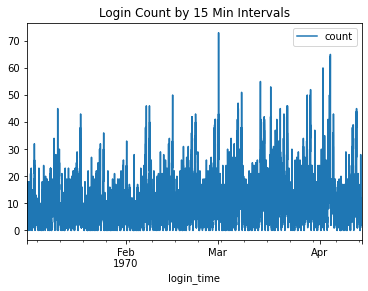

In [87]:
logins_15min.plot(title="Login Count by 15 Min Intervals")

#### There appears to be a regular cycle

<AxesSubplot:title={'center':'Login Count by Day of Week'}, xlabel='weekday'>

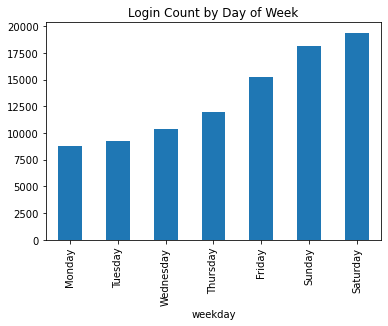

In [86]:
logins_df.groupby(['weekday'])['weekday'].count().sort_values().plot(kind='bar', title="Login Count by Day of Week")

#### Logins increase as we progress through the week toward the weekend

<AxesSubplot:title={'center':'Login Count by Week of Year'}, xlabel='week_num'>

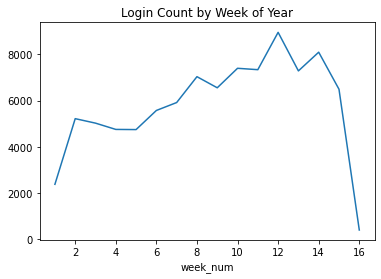

In [84]:
logins_df.groupby(['week_num'])['day_num'].count().plot(title="Login Count by Week of Year")


#### Prior to the partial month of April, the year-to-date trend of logins was increasing

In [75]:
logins_15 = logins_15min.reset_index()
logins_15['time'] = logins_15['login_time'].dt.time

<AxesSubplot:title={'center':'Login Count by Time'}, xlabel='time'>

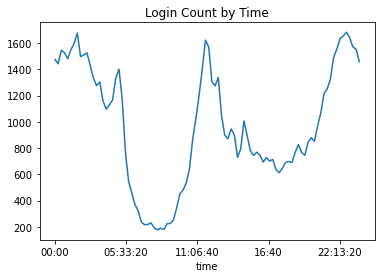

In [81]:
logins_15.groupby(['time'])['count'].sum().plot(title = "Login Count by Time")

In [88]:
logins_15.groupby(['time'])['count'].sum().sort_values()

time
08:00:00     176
08:30:00     179
08:15:00     190
07:45:00     192
07:00:00     215
            ... 
22:15:00    1634
23:00:00    1641
22:30:00    1654
01:45:00    1676
22:45:00    1682
Name: count, Length: 96, dtype: int64

#### Logins cycle daily peaks from around 10:15 PM to 1:45 AM, lows from 7 AM to 8:30AM, and back up at lunch time.

## Part 2 ‑ Experiment and metrics design

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

The metric would be the mean number of daily tolls collected.  If the mean number of daily tolls experiences a significant and sustained increase, it would coincide with more daily activity crossing the toll bridge due to the new reimbursement.

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

(Assuming COVID doesn't exist in this scenario)

I would propose an A/B test, such as traffic to a website, this is traffic to a toll booth.  Assuming the cities have been collecting toll information, I would calculate the needed sample size and convert that to an average number of days needed to run the test, also taking into consideration the budgets and expectations of the city managers.  I would pick a non-winter start date for reimbursing toll costs and advertise those start and end dates to the driver partners.  This data collection for tolls that will be reimubrsed is dataset B.  I would collect the toll activity for the same date period from a year prior as dataset A, the baseline.

To check there isn't a likelihood of a large population increase driving additional tolls, I would check the mean daily tolls collected hasn't significantly increased year over year.

The null hypothesis is that the mean daily number of tolls of dataset A equals the mean daily number of tolls of dataset B.  To make the comparison of means, since I have the same number of days in each sample, I would use a two-sample pooled t-test on the mean difference, variance and number of data points.  The larger the t-score, the larger the difference between our A and B datasets.  

I would use a p-value of 0.05 to deterimine when it is safe to reject the null hypothesis that the means are equal.  The p-value and degrees of freedom determine the threshold on the t-distribution.  If the calculated t-value is greater, the null hypothesis can be rejected and I could recommend to the city operations team that the reimbursement of tolls would increase cross-city traffic.   

Caveats to explain to the city managers - 95% confidence, seasonality, outside influences such as price of oil/fuel/economy, travel restrictions.

## Part 3 ‑ Predictive modeling

In [2]:
ultimate_df = pd.read_json (r'ultimate_data_challenge.json')

### Exploratory Data Analysis

In [6]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [8]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
# Range of sign up dates
print(ultimate_df.signup_date.min(), ultimate_df.signup_date.max())

2014-01-01 2014-01-31


In [10]:
# Range of last trip dates
print(ultimate_df.last_trip_date.min(), ultimate_df.last_trip_date.max())

2014-01-01 2014-07-01


In [3]:
# Remove any rows with null
ultimate2 = ultimate_df.dropna().copy()
ultimate2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [14]:
print("Percent records remaining: "+"{:.1%}".format(len(ultimate2) / len(ultimate_df)))

Percent records remaining: 82.9%


<AxesSubplot:title={'center':'Users by City'}, xlabel='city'>

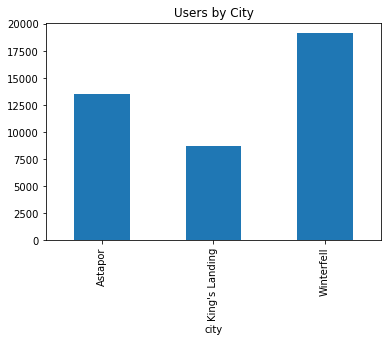

In [50]:
# City volumes
ultimate2.groupby(['city'])['city'].count().plot(kind="bar", title="Users by City")

<AxesSubplot:title={'center':'Avg Rating BY Driver Trend'}, xlabel='avg_rating_by_driver'>

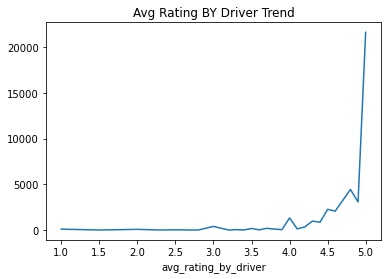

In [24]:
# Check ratings 1-5
ultimate2.groupby(['avg_rating_by_driver'])['avg_rating_by_driver'].count().plot(title="Avg Rating BY Driver Trend")

In [25]:
print("Percent rating BY driver = 5: "+"{:.1%}".format(len(ultimate2[ultimate2['avg_rating_by_driver'] == 5.0]) / len(ultimate2)))

Percent rating BY driver = 5: 52.1%


<AxesSubplot:title={'center':'Avg Rating OF Driver Trend'}, xlabel='avg_rating_of_driver'>

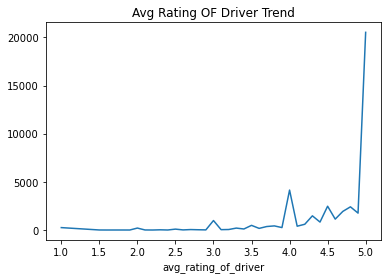

In [26]:
ultimate2.groupby(['avg_rating_of_driver'])['avg_rating_of_driver'].count().plot(title="Avg Rating OF Driver Trend")

In [27]:
print("Percent rating OF driver = 5: "+"{:.1%}".format(len(ultimate2[ultimate2['avg_rating_of_driver'] == 5.0]) / len(ultimate2)))

Percent rating OF driver = 5: 49.5%


In [44]:
# Check outliers of trips in first 30 days
ultimate2.trips_in_first_30_days.sort_values(ascending=False).head()

18514    125
99        73
3030      71
29070     63
48804     58
Name: trips_in_first_30_days, dtype: int64

In [45]:
ultimate2.trips_in_first_30_days.median()

1.0

In [55]:
# City ratings
ultimate2.groupby(['city'])['avg_rating_by_driver'].mean()

city
Astapor           4.794766
King's Landing    4.851897
Winterfell        4.728976
Name: avg_rating_by_driver, dtype: float64

In [54]:
ultimate2.groupby(['city'])['avg_rating_of_driver'].mean()

city
Astapor           4.630883
King's Landing    4.707943
Winterfell        4.532514
Name: avg_rating_of_driver, dtype: float64

In [56]:
# City distance
ultimate2.groupby(['city'])['avg_dist'].mean()

city
Astapor           5.151244
King's Landing    5.714379
Winterfell        5.561285
Name: avg_dist, dtype: float64

In [95]:
# City weekdays
ultimate2.groupby(['city'])['weekday_pct'].mean()

city
Astapor           60.702265
King's Landing    63.480046
Winterfell        60.625484
Name: weekday_pct, dtype: float64

In [47]:
# Check outliers of average surge
ultimate2.avg_surge.sort_values(ascending=False).head()

13861    8.00
30477    5.75
2817     5.00
19191    5.00
1405     4.75
Name: avg_surge, dtype: float64

In [66]:
print("Percent with increased surge > 1: "+"{:.1%}".format(len(ultimate2[ultimate2.avg_surge > 1])/len(ultimate2)))

Percent with increased surge > 1: 35.2%


In [70]:
print("Percent using Ultimate Black: "+"{:.1%}".format(len(ultimate2[ultimate2.ultimate_black_user==True])/len(ultimate2)))

Percent using Ultimate Black: 38.4%


In [86]:
city_riders = pd.DataFrame(ultimate2.groupby(['city'])['city'].count())
city_riders.columns = ["riders"]
city_riders

,riders
city,
Astapor,13509
King's Landing,8775
Winterfell,19161


In [94]:
city_riders = pd.DataFrame(ultimate2.groupby(['city'])['city'].count())
city_riders.columns = ["riders"]
city_UB = pd.DataFrame(ultimate2[ultimate2.ultimate_black_user==True].groupby(['city'])['city'].count())
city_UB.columns = ["UB"]
city_ridersUB = city_riders.merge(city_UB, on="city")
city_ridersUB['rate'] = city_ridersUB.UB / city_ridersUB.riders
city_ridersUB

,riders,UB,rate
city,,,
Astapor,13509,5406,0.400178
King's Landing,8775,3708,0.422564
Winterfell,19161,6805,0.355148


<AxesSubplot:title={'center':'Rider Phone Type'}, xlabel='phone'>

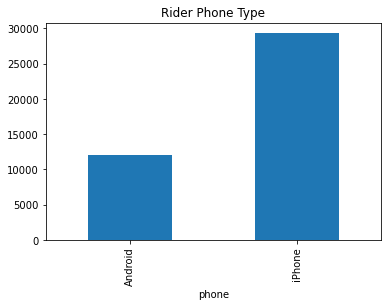

In [11]:
# Check phone use
ultimate2.groupby(['phone'])['phone'].count().plot(kind="bar", title="Rider Phone Type")

In [4]:
# Convert to datetime
ultimate2.last_trip_date = pd.to_datetime(ultimate2.last_trip_date)
ultimate2.last_trip_date = ultimate2.last_trip_date.dt.normalize()

In [5]:
# Identify active riders, last trip within 30 days
ultimate2['active'] = False
ultimate2.loc[(ultimate2.last_trip_date >= ultimate2.last_trip_date.max()-timedelta(30)), 'active'] = True

In [125]:
print("Percent active riders: "+"{:.1%}".format(len(ultimate2[ultimate2.active==True])/len(ultimate2)))

Percent active riders: 41.1%


#### EDA Notes
- After removing rows with null, nearly 83% of original 5000 records were kept
- Most riders from Winterfell, least from King's Landing, and ratings averages are close
- Most Ultimate Black riders from Winterfell, but 36% of riders.  40 - 42% out of Astapor and King's Landing
- Average ride in Winterfell and King's Landing is about 5.5 - 5.7 miles, and less at Astapor about 5.2 
- The three cities average about 60-63% weekday use
- Most participants are pleased, about half of review ratings, both OF and BY drivers, were 5 stars
- There are outliers of "power riders" with very many trips in the first 30 days, which has a mean of 2.3 and median of 1 trip
- About a third of riders will experience volume surge, with one rider jumping to a multiplier of 8
- Most riders use iPhone over Android by more than double
- 41% of riders are active, riding within the last 30 days

## Logistic Regression Model

A binary classification model - Is the rider active after six months?

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
# Drop date fields not being used in model
ultimate3 = ultimate2.drop(['signup_date', 'last_trip_date'], axis=1)

Convert all text fields to numeric

In [46]:
# Convert city names to alphabetical order, 1, 2, 3
ultimate3['city_num'] = 1
ultimate3.loc[(ultimate3.city == "King's Landing"), 'city_num'] = 2
ultimate3.loc[(ultimate3.city == "Winterfell"), 'city_num'] = 3
ultimate3.city_num.value_counts()

3    19161
1    13509
2     8775
Name: city_num, dtype: int64

In [50]:
# Convert phone to binary
ultimate3['phone01'] = ultimate3['phone'].apply(lambda x: 1 if x == "iPhone" else 0)

In [51]:
# Convert active to binary
ultimate3['active01'] = ultimate3['active'].apply(lambda x: 1 if x == True else 0)

In [55]:
# Convert ultimate_black_user to binary
ultimate3['ub01'] = ultimate3['ultimate_black_user'].apply(lambda x: 1 if x == True else 0)

In [62]:
# Separate X, y, train, test, validate samples
y = ultimate3.active01
X = ultimate3.drop(['active', 'active01', 'phone', 'city', 'ultimate_black_user'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=7)

In [63]:
# Steps, pipeline, scale, fit
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 7))]
pipeline = Pipeline(steps)
logreg_scaled = pipeline.fit(X_train, y_train)

In [65]:
# Accuracy on testing
print("The testing accuracy is "+"{:.1%}".format(logreg_scaled.score(X_test, y_test)))

The testing accuracy is 67.4%


### Evaluate

In [78]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.67667994 0.67788636 0.66775244 0.67933406 0.68259139]
Average 5-Fold CV Score: 0.6768488358064905


I don't believe there is overfitting due to the low variation in cross-validation.

In [79]:
# Classification Report
y_pred = logreg_scaled.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      4882
           1       0.63      0.50      0.55      3407

    accuracy                           0.67      8289
   macro avg       0.66      0.65      0.65      8289
weighted avg       0.67      0.67      0.67      8289



Better recall for riders who fail to remain active than identifying active

In [80]:
# confusion matrix percentages
cm = confusion_matrix(y_test, y_pred)
cmpct = cm / cm.sum(axis=1).reshape(-1,1)
print(cmpct)

[[0.79803359 0.20196641]
 [0.50484297 0.49515703]]


The model is strongest predicting riders who fail to remain active and 50% accuracy identifying those who remain active.  This may be impacted by the data having 41% active riders and over-represented by the inactive riders

### Feature Ranking

In [74]:
features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city_num', 'phone01', 'ub01']

In [75]:
# Check coefficients
logreg = LogisticRegression(random_state = 7)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg.fit(X_train,y_train)
std_coef = logreg.coef_.reshape(-1,1).tolist()
feature_names = [feature.title() for feature in features]
coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
pd.set_option('display.max_rows', None)
print(coef_df)

                            coef
Phone01                 1.107908
Ub01                    0.875108
Avg_Surge              -0.679925
City_Num                0.187034
Avg_Rating_By_Driver   -0.161551
Trips_In_First_30_Days  0.099810
Avg_Rating_Of_Driver   -0.041630
Avg_Dist               -0.030744
Surge_Pct               0.008452
Weekday_Pct             0.000403


C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [69]:
# Check correlations
ultimate3.drop(['active', 'ultimate_black_user'], axis=1).corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_num,phone01,active01,ub01
trips_in_first_30_days,1.000000,-0.011849,-0.000262,0.005370,0.055556,-0.136471,-0.045788,0.059013,0.056367,0.198816,0.115066
avg_rating_of_driver,-0.011849,1.000000,-0.022209,-0.001696,0.012975,0.034877,0.122413,-0.076782,-0.027327,-0.011829,-0.003292
avg_surge,-0.000262,-0.022209,1.000000,0.795737,-0.118999,-0.085750,0.012418,-0.035643,0.013029,-0.004185,-0.070613
surge_pct,0.005370,-0.001696,0.795737,1.000000,-0.155179,-0.110894,0.019703,-0.064992,0.014561,0.011126,-0.099814
weekday_pct,0.055556,0.012975,-0.118999,-0.155179,1.000000,0.102048,0.018312,-0.003630,0.004060,0.010423,0.033964
avg_dist,-0.136471,0.034877,-0.085750,-0.110894,0.102048,1.000000,0.083190,0.032668,-0.025115,-0.089498,0.027206
avg_rating_by_driver,-0.045788,0.122413,0.012418,0.019703,0.018312,0.083190,1.000000,-0.078651,-0.012638,-0.034720,0.005708
city_num,0.059013,-0.076782,-0.035643,-0.064992,-0.003630,0.032668,-0.078651,1.000000,0.002430,0.073666,-0.043649
phone01,0.056367,-0.027327,0.013029,0.014561,0.004060,-0.025115,-0.012638,0.002430,1.000000,0.233722,0.076271
active01,0.198816,-0.011829,-0.004185,0.011126,0.010423,-0.089498,-0.034720,0.073666,0.233722,1.000000,0.217365


### Correlation notes, 10% or greater
- The phone you use, whether you use Ultimate_Black, and the amount of trips taken in first 30 days are the most correlated to identifying an active account in six months - 20% - 23% correlation 
- The amount of trips taken in first 30 days has a 12% correlation to Ultimate_Black use
- Ultimate_Black use can assist with avoiding surge, a -10% correlation
- A small correlation between ratings OF and BY the driver
- More travel during weekdays, and more distance, decreases chances of surge impact
- A small correlation between weekday use and distance traveled
- A small negative correlation between distance and trips, fewer rides with longer distance or more rides with shorter distance
- The two surge columns correlate strongly

Logistic regression is a great baseline algorithm for predicting a binary outcome, such as this example whether a rider will still be active in six months.  The relationship between the features and target are not too complex, and the feature weights are interpretable so that the results can be shared with the managers of Ultimate.  Another alternative to consider is Random Forest to improve classification for its additional robustness, less preprocessing and reduced impact of correlations.

67% accuracy allows rider planning by Ultimate managers better than a 50/50 guess or trial and error.  Obviously, frequency of trips is an indicator of success, as well as utilizing Ultimate Black.  Ultimate can offer incentives to encourage lower frequency users to try more often and "get hooked", or note the ability to avoid congestion surges.  Also, the indication that type of phone is important suggests comparing the ease of use of the rider software between the devices.